# Experiment 01: Baseline Strategies

**Objective:** Establish the performance benchmarks for standard industrial injection strategies.
**Consistency:** Uses the centralized `physics.py` engine for all fluid properties and boundary conditions.

We compare:
1. **Constant Pressure (CP):** Safe, but slows down as back-pressure builds.
2. **Constant Rate (CR):** Fast, but risks fracturing the rock (exceeding fracture pressure).

**Output:** Saves `baseline_saturation_history.npy` for comparison in later notebooks.

In [1]:
import jax
import jax.numpy as jnp
from jax import lax
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# --- IMPORT SINGLE SOURCE OF TRUTH ---
# Add parent directory to path to import physics.py
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import physics

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)

print(f"Physics Engine Loaded. Grid: {physics.NX}x{physics.NY}")

Physics Engine Loaded. Grid: 100x50


## 1. Define Helper for Constant Rate
The `physics.py` module standardizes `lbm_step_pressure`. Here we define a local helper for **Constant Rate** injection using the same physics kernels.

In [2]:
@jax.jit
def lbm_step_rate(carry, target_velocity_val):
    """
    Runs one LBM step with Constant Inlet Velocity (Rate).
    Uses physics.collision_stream and physics.zou_he_inlet_velocity.
    """
    f, salt, mask = carry
    
    # 1. Physics Step (Collision & Streaming)
    rho_local = jnp.sum(f, axis=-1)
    
    # Interpolate Relaxation Time (Tau)
    tau_eff = physics.TAU_CO2 + (physics.TAU_BRINE - physics.TAU_CO2) * \
              (rho_local - physics.RHO_CO2_INIT)/(physics.RHO_BRINE - physics.RHO_CO2_INIT)
    tau_safe = jnp.maximum(tau_eff, 0.52)
    
    f, rho, ux, uy = physics.collision_stream(f, salt, mask, tau_safe)
    
    # 2. Boundary Condition: Constant Rate (Fix Velocity, Calc Rho)
    f_new, rho_inlet_actual = physics.zou_he_inlet_velocity(f, target_velocity_val)
    
    # 3. Solute Transport (Salt)
    ux_s = jnp.clip(ux, -0.2, 0.2)
    uy_s = jnp.clip(uy, -0.2, 0.2)
    
    grad_salt_x = (jnp.roll(salt, -1, axis=0) - jnp.roll(salt, 1, axis=0)) / 2.0
    grad_salt_y = (jnp.roll(salt, -1, axis=1) - jnp.roll(salt, 1, axis=1)) / 2.0
    laplacian = (jnp.roll(salt, -1, axis=0) + jnp.roll(salt, 1, axis=0) + 
                 jnp.roll(salt, -1, axis=1) + jnp.roll(salt, 1, axis=1) - 4*salt)
    
    salt_new = salt + (-(ux_s * grad_salt_x + uy_s * grad_salt_y) + physics.D_SALT * laplacian)
    salt_new = salt_new.at[0, :].set(0.0) # Fresh CO2 has no salt
    salt_new = jnp.clip(salt_new, 0.0, 5.0)
    
    # 4. Precipitation
    new_precip = jax.nn.sigmoid(20 * (salt_new - physics.K_SP))
    mask_new = jnp.maximum(mask, new_precip)
    
    # 5. Metrics
    pore_vol = jnp.sum(1-mask_new) + 1e-6
    s_co2 = jnp.sum((rho < (physics.RHO_BRINE + physics.RHO_CO2_INIT)/2.0) * (1-mask_new)) / pore_vol
    
    # Track Inlet Pressure (Risk Factor)
    inlet_pressure = jnp.mean(rho_inlet_actual[0, :] - physics.RHO_CO2_INIT)
    
    return (f_new, salt_new, mask_new), (s_co2, inlet_pressure)

## 2. Initialization & Setup

In [3]:
NX, NY = physics.NX, physics.NY
TIME_STEPS = 1000

# Random Geometry (Reproducible)
key = jax.random.PRNGKey(42)
mask_init = jax.random.bernoulli(key, p=0.25, shape=(NX, NY)).astype(jnp.float64)
mask_init = mask_init.at[0:5, :].set(0.0).at[-5:, :].set(0.0) # Clear Inlet/Outlet

# Initial Fields
rho_init = jnp.ones((NX, NY)) * physics.RHO_BRINE
u_init = jnp.zeros((NX, NY))
f_init = physics.get_equilibrium(rho_init, u_init, u_init)
salt_init = jnp.ones((NX, NY)) * 0.5

state_init = (f_init, salt_init, mask_init)

In [4]:
# --- APPENDIX A: SIMULATION CONFIGURATION ---
# Dynamically pulls values from physics.py to ensure consistency in the report
print("="*60)
print("       APPENDIX A: SIMULATION CONFIGURATION")
print("="*60)
print(f"1. Domain Geometry (Source: physics.py)")
print(f"   - Grid Dimensions:        {physics.NX} x {physics.NY}")
print(f"   - Simulation Duration:    {TIME_STEPS} steps")
print(f"   - Boundary Condition:     Zou-He (Pressure/Velocity)")
print(f"\n2. Fluid Parameters")
print(f"   - Brine Density:          {physics.RHO_BRINE:.2f} (Lattice Units)")
print(f"   - CO2 Init Density:       {physics.RHO_CO2_INIT:.2f}")
print(f"   - Brine Viscosity (Tau):  {physics.TAU_BRINE:.2f}")
print(f"   - CO2 Viscosity (Tau):    {physics.TAU_CO2:.2f}")
print(f"   - Shan-Chen G Strength:   {physics.G_INT:.2f}")
print(f"\n3. Reactive Transport")
print(f"   - Salt Diffusion (D):     {physics.D_SALT:.3f}")
print(f"   - Solubility Limit (Ksp): {physics.K_SP:.2f}")
print("="*60)

       APPENDIX A: SIMULATION CONFIGURATION
1. Domain Geometry (Source: physics.py)
   - Grid Dimensions:        100 x 50
   - Simulation Duration:    1000 steps
   - Boundary Condition:     Zou-He (Pressure/Velocity)

2. Fluid Parameters
   - Brine Density:          1.00 (Lattice Units)
   - CO2 Init Density:       0.10
   - Brine Viscosity (Tau):  1.00
   - CO2 Viscosity (Tau):    0.90
   - Shan-Chen G Strength:   -1.00

3. Reactive Transport
   - Salt Diffusion (D):     0.050
   - Solubility Limit (Ksp): 1.10


## 3. Run Simulations

In [5]:
# --- 1. Constant Pressure Simulation ---
# P_in = 0.03 (Lattice Units)
print("Running Constant Pressure Baseline...")
p_schedule = jnp.ones(TIME_STEPS) * 0.03
final_state_P, (hist_sat_P, hist_flux_P) = lax.scan(
    physics.lbm_step_pressure, 
    state_init, 
    p_schedule
)

# --- 2. Constant Rate Simulation ---
# u_in = 0.03 (Lattice Units)
print("Running Constant Rate Baseline...")
rate_schedule = jnp.ones(TIME_STEPS) * 0.03
final_state_R, (hist_sat_R, hist_pressure_R) = lax.scan(
    lbm_step_rate, 
    state_init, 
    rate_schedule
)

Running Constant Pressure Baseline...
Running Constant Rate Baseline...


## 4. Visualization & Analysis

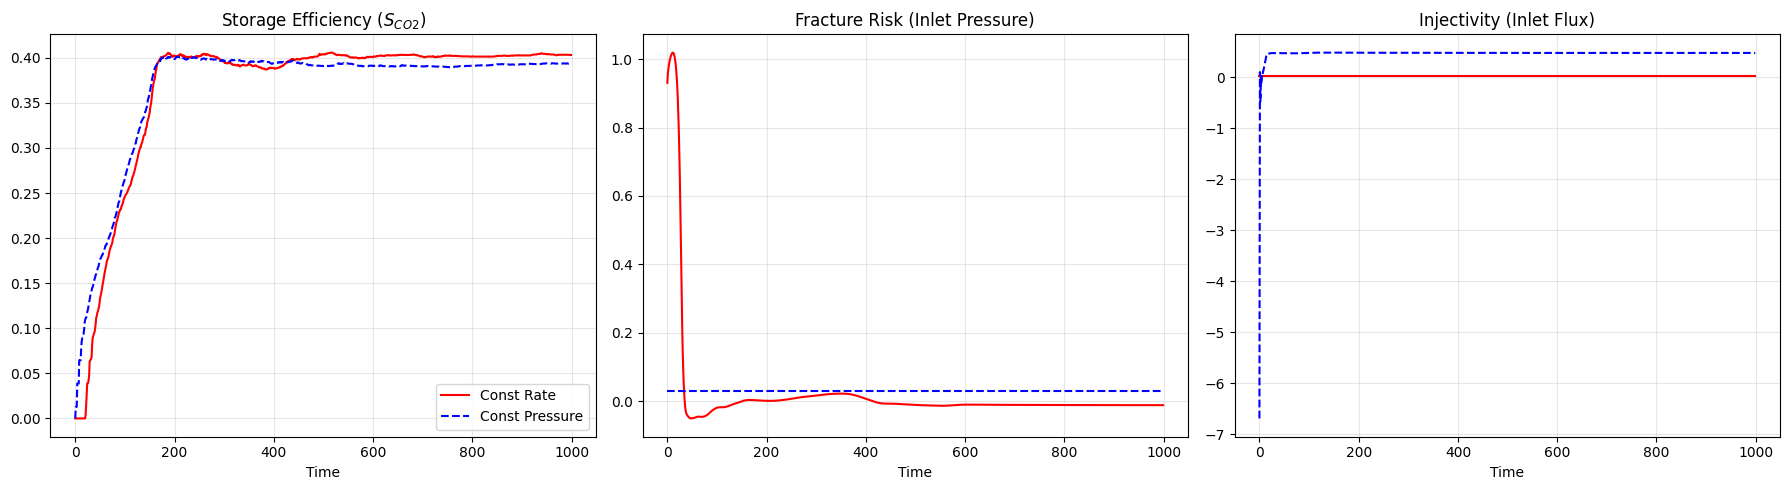

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Saturation
ax[0].plot(hist_sat_R, 'r-', label='Const Rate')
ax[0].plot(hist_sat_P, 'b--', label='Const Pressure')
ax[0].set_title("Storage Efficiency ($S_{CO2}$)")
ax[0].set_xlabel("Time")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Risk (Pressure)
ax[1].plot(hist_pressure_R, 'r-', label='Const Rate (Risk)')
ax[1].plot(p_schedule, 'b--', label='Const Pressure (Safe)')
ax[1].set_title("Fracture Risk (Inlet Pressure)")
ax[1].set_xlabel("Time")
ax[1].grid(True, alpha=0.3)

# Injectivity (Flux)
ax[2].plot(rate_schedule, 'r-', label='Const Rate (Forced)')
ax[2].plot(hist_flux_P, 'b--', label='Const Pressure (Declines)')
ax[2].set_title("Injectivity (Inlet Flux)")
ax[2].set_xlabel("Time")
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# --- APPENDIX B: BASELINE RESULTS SUMMARY ---
print("="*60)
print("       APPENDIX B: BASELINE RESULTS SUMMARY")
print("="*60)
print(f"{ 'STRATEGY':<20} | { 'PARAMETER':<15} | { 'FINAL SATURATION':<15} ")
print("-"*60)

print(f"{ 'Constant Pressure':<20} | P={0.03:<13} | {hist_sat_P[-1]:.4f}")
print(f"{ 'Constant Rate':<20} | U={0.03:<13} | {hist_sat_R[-1]:.4f}")

print("-"*60)
print("NOTE: Constant Pressure is selected as the primary baseline")
print("for subsequent safety-constrained optimization tasks.")
print("="*60)

       APPENDIX B: BASELINE RESULTS SUMMARY
STRATEGY             | PARAMETER       | FINAL SATURATION 
------------------------------------------------------------
Constant Pressure    | P=0.03          | 0.3936
Constant Rate        | U=0.03          | 0.4031
------------------------------------------------------------
NOTE: Constant Pressure is selected as the primary baseline
for subsequent safety-constrained optimization tasks.


## 5. Visualization: Fluid Maps (Initial vs Final)
Visualizing the standard displacement pattern for the Constant Pressure Baseline.

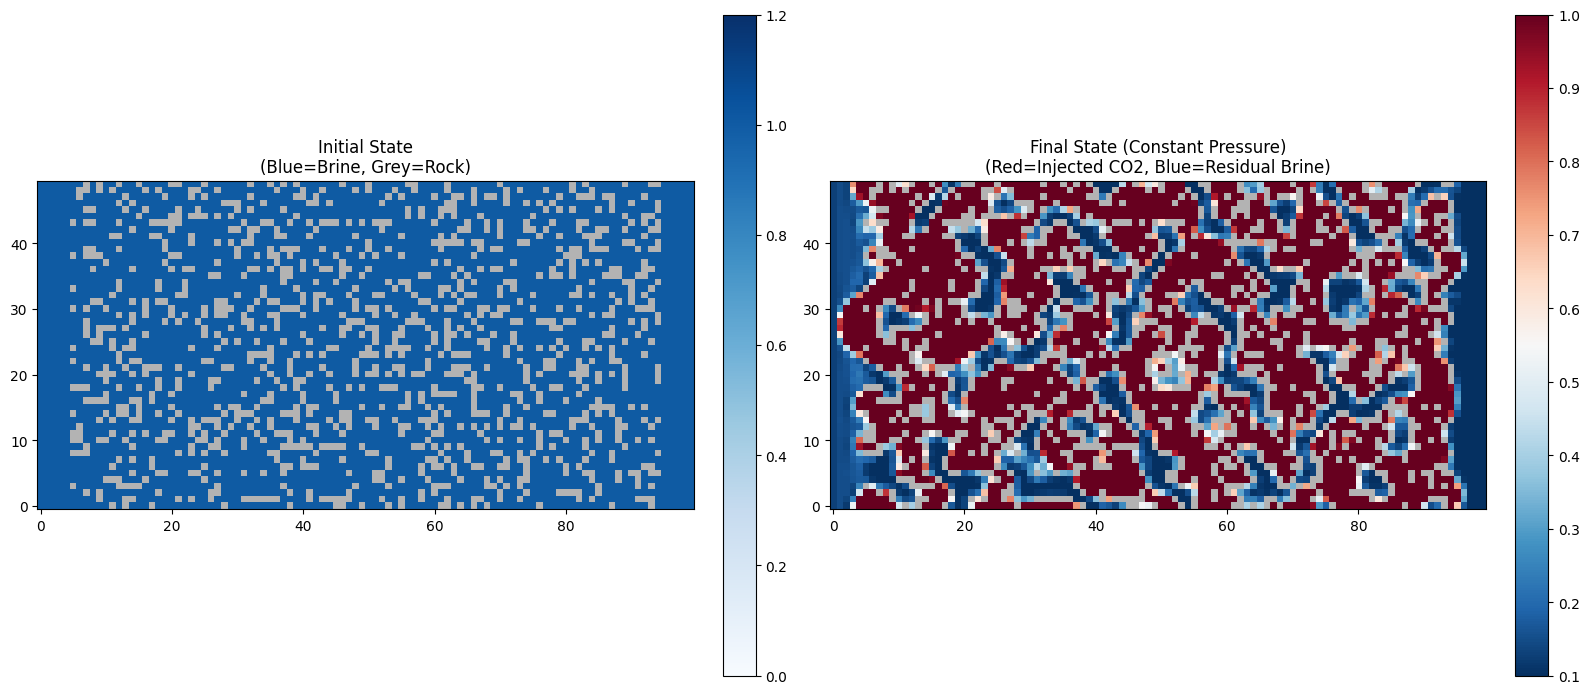

In [8]:
f_final, salt_final, mask_final = final_state_P
rho_final = jnp.sum(f_final, axis=-1)

# Prepare Data
f_init, _, mask_init_val = state_init
rho_init_val = jnp.sum(f_init, axis=-1)

rho_init_masked = np.ma.masked_where(mask_init_val > 0.5, rho_init_val)
rho_final_masked = np.ma.masked_where(mask_final > 0.5, rho_final)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# Map A: Initial Condition
ax[0].imshow(mask_init_val.T, cmap='gray_r', origin='lower', alpha=0.3)
im0 = ax[0].imshow(rho_init_masked.T, cmap='Blues', origin='lower', vmin=0.0, vmax=1.2)
ax[0].set_title(f"Initial State\n(Blue=Brine, Grey=Rock)")
plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

# Map B: Final Condition (Constant Pressure)
ax[1].imshow(mask_final.T, cmap='gray_r', origin='lower', alpha=0.3)
im1 = ax[1].imshow(rho_final_masked.T, cmap='RdBu_r', origin='lower', 
                   vmin=physics.RHO_CO2_INIT, vmax=physics.RHO_BRINE)
ax[1].set_title(f"Final State (Constant Pressure)\n(Red=Injected CO2, Blue=Residual Brine)")
plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [9]:
# Save Data for Optimization Comparison
baseline_data = {
    "pressure_mode_saturation": np.array(hist_sat_P),
    "rate_mode_saturation": np.array(hist_sat_R),
    "steps": TIME_STEPS
}

np.save("baseline_saturation_history.npy", baseline_data)
print("Baseline history saved to baseline_saturation_history.npy")

Baseline history saved to baseline_saturation_history.npy
